Так, як моя попередня робота створена за допомогою згорткової нейромережі, яка мала в собі два різні типи шару: Conv2D та MaxPooling2D, то я спробував підвищити точність моделі. Спробував додати ще один шар Conv2D та збільшити кількість фільтрів до 128. Також спробував зробити функцію зупинки (early_stopping)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop,SGD,Adagrad,Adadelta,Adam,Adamax,Nadam
from sklearn.metrics import confusion_matrix

In [82]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [83]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [84]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

Normalize the data dimensions so that they are of approximately the same scale.

In [85]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [86]:
print(str(len(x_train)))
print(str(len(x_test)))

60000
10000


In [87]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


Create the model architecture

In [88]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))



In [89]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 7, 7, 256)         0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 7, 7, 256)        

Compile the model

In [90]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [91]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Train the model

In [92]:
history = model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_data=(x_valid, y_valid),
         callbacks=[early_stopping])  # Додаємо функцію зупинки

Epoch 1/20
430/430 [==============================] - 12s 24ms/step - loss: 0.5379 - accuracy: 0.8010 - val_loss: 0.3065 - val_accuracy: 0.8904
Epoch 2/20
430/430 [==============================] - 10s 24ms/step - loss: 0.3210 - accuracy: 0.8823 - val_loss: 0.2566 - val_accuracy: 0.9040
Epoch 3/20
430/430 [==============================] - 10s 23ms/step - loss: 0.2784 - accuracy: 0.8978 - val_loss: 0.2308 - val_accuracy: 0.9150
Epoch 4/20
430/430 [==============================] - 10s 24ms/step - loss: 0.2488 - accuracy: 0.9071 - val_loss: 0.2297 - val_accuracy: 0.9118
Epoch 5/20
430/430 [==============================] - 10s 23ms/step - loss: 0.2294 - accuracy: 0.9145 - val_loss: 0.2069 - val_accuracy: 0.9230
Epoch 6/20
430/430 [==============================] - 10s 24ms/step - loss: 0.2128 - accuracy: 0.9211 - val_loss: 0.2025 - val_accuracy: 0.9236
Epoch 7/20
430/430 [==============================] - 10s 24ms/step - loss: 0.2005 - accuracy: 0.9253 - val_loss: 0.1901 - val_accuracy:

In [93]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9276999831199646


In [94]:
def plot_learning_history(history_dict, metric='accuracy'):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    plt.plot(epochs, history_dict[metric], 'bo', label=f'Training {metric}')
    plt.plot(epochs, history_dict[f'val_{metric}'], 'b', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

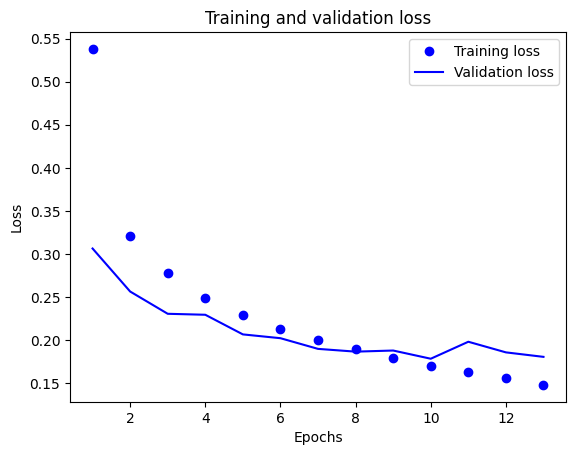

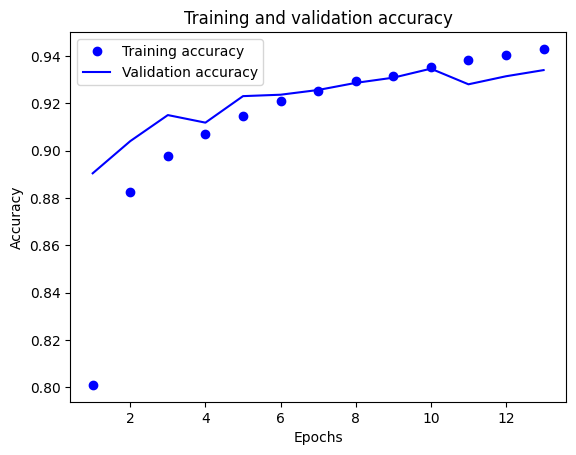

In [95]:
plot_learning_history(history.history, metric='accuracy')

In [97]:
fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

313/313 [==============================] - 1s 3ms/step


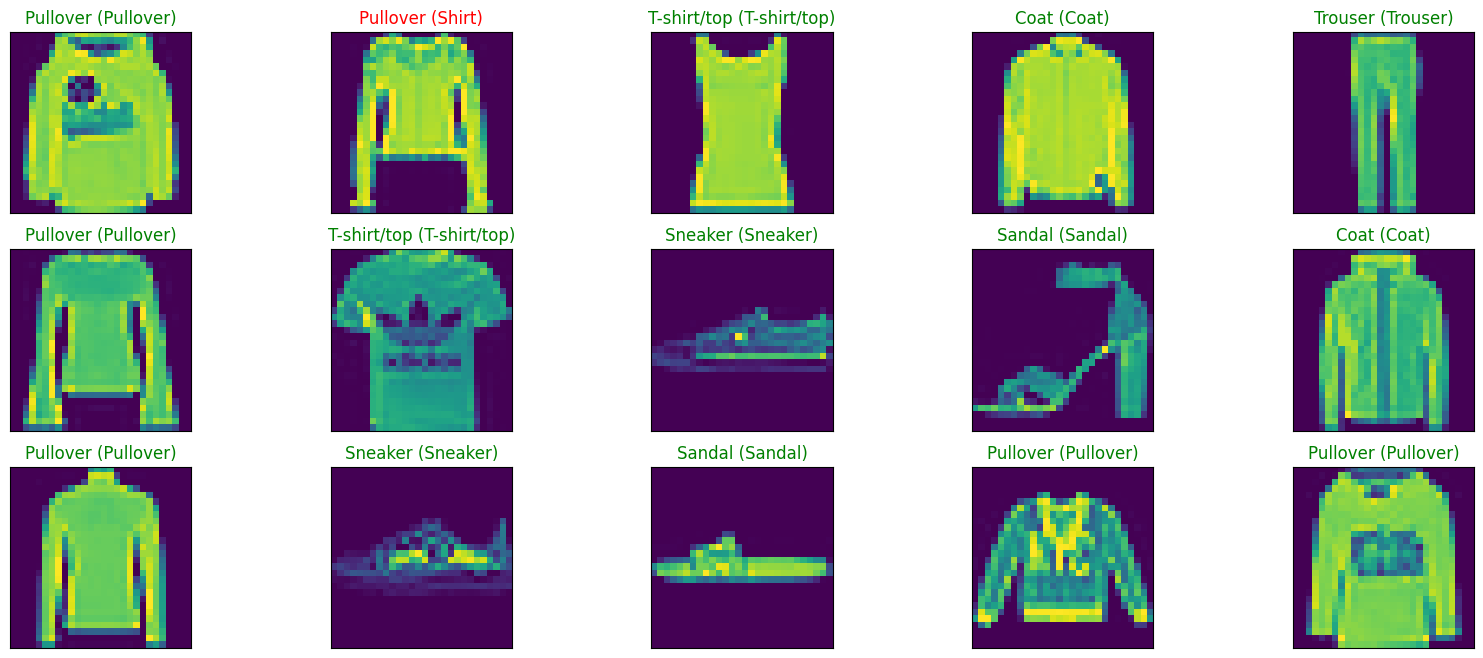

In [98]:
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index],
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

Створення нейромережі, що використовує VGG16 в якості згорткової основи.

In [2]:
from keras.applications import VGG16
import cv2
import numpy as np
from keras.datasets import fashion_mnist
from keras.applications.vgg16 import preprocess_input


In [20]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [21]:
x_train_resized = np.array([cv2.resize(x, (32, 32)) for x in x_train])
x_test_resized = np.array([cv2.resize(x, (32, 32)) for x in x_test])

x_train_resized = np.stack((x_train_resized,) * 3, axis=-1)
x_test_resized = np.stack((x_test_resized,) * 3, axis=-1)

x_train_preprocessed = preprocess_input(x_train_resized)
x_test_preprocessed = preprocess_input(x_test_resized)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [23]:
history = model.fit(
    x_train_preprocessed, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_preprocessed, y_test)
)

Epoch 1/10
938/938 [==============================] - 15s 14ms/step - loss: 1.2851 - accuracy: 0.7289 - val_loss: 0.4972 - val_accuracy: 0.8222
Epoch 2/10
938/938 [==============================] - 14s 14ms/step - loss: 0.5678 - accuracy: 0.7965 - val_loss: 0.4717 - val_accuracy: 0.8330
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.5094 - accuracy: 0.8143 - val_loss: 0.4363 - val_accuracy: 0.8411
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4837 - accuracy: 0.8249 - val_loss: 0.4199 - val_accuracy: 0.8514
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4702 - accuracy: 0.8281 - val_loss: 0.4180 - val_accuracy: 0.8491
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4518 - accuracy: 0.8354 - val_loss: 0.4181 - val_accuracy: 0.8492
Epoch 7/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4444 - accuracy: 0.8377 - val_loss: 0.4100 - val_accuracy:

In [24]:
model.save(
"/content/drive/MyDrive/prepared_train_data/models/vgg16_basesd_model.hdf5")

точність моделі досить низька, спробуємо донавчання

In [25]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Зробимо донавчання останніх трьох шарів

In [26]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model = Sequential([
   base_model,
   Flatten(),
   Dense(256, activation="relu"),
   Dense(10, activation='softmax'),
])

In [27]:
from keras import optimizers

modified_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=["acc"]
)

In [28]:
history = modified_model.fit(
    x_train_preprocessed, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_preprocessed, y_test)
)

Epoch 1/10
938/938 [==============================] - 20s 20ms/step - loss: 0.8855 - acc: 0.7771 - val_loss: 0.4614 - val_acc: 0.8444
Epoch 2/10
938/938 [==============================] - 19s 21ms/step - loss: 0.3632 - acc: 0.8722 - val_loss: 0.3809 - val_acc: 0.8718
Epoch 3/10
938/938 [==============================] - 18s 19ms/step - loss: 0.2980 - acc: 0.8936 - val_loss: 0.3397 - val_acc: 0.8857
Epoch 4/10
938/938 [==============================] - 19s 21ms/step - loss: 0.2607 - acc: 0.9065 - val_loss: 0.3399 - val_acc: 0.8870
Epoch 5/10
938/938 [==============================] - 20s 21ms/step - loss: 0.2335 - acc: 0.9160 - val_loss: 0.3220 - val_acc: 0.8911
Epoch 6/10
938/938 [==============================] - 19s 21ms/step - loss: 0.2123 - acc: 0.9232 - val_loss: 0.3282 - val_acc: 0.8917
Epoch 7/10
938/938 [==============================] - 18s 19ms/step - loss: 0.1929 - acc: 0.9303 - val_loss: 0.3133 - val_acc: 0.8938
Epoch 8/10
938/938 [==============================] - 19s 21ms

донавчання допомогло підвищити нашу точність до 0,9451 на навчальних даних та 0,8989 на тестових